# Salary Prediction
## Description
#### Your job as a data scientist is in this assignment is to examine a set of job postings with salaries and then predict salaries for a new set of job postings.

## The task
#### You must build a model to predict the salaries for the job postings contained in test_features.csv.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
# import test data
test_data = pd.read_csv("test_features.csv")
test_data.head(2)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47


In [3]:
# check data shape
test_data.shape

(1000000, 8)

In [4]:
# import train data
training_data = pd.read_csv("train_features.csv")
training_data.head(2)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73


In [5]:
# check data shape
training_data.shape

(1000000, 8)

In [6]:
# import salaries data
training_salaries_data = pd.read_csv("train_salaries.csv")
training_salaries_data.head(2)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101


In [7]:
# check data shape
training_salaries_data.shape

(1000000, 2)

In [8]:
# merge features and target (salaries) into a single dataframe
data_for_model = pd.merge(training_data, training_salaries_data, on='jobId')
data_for_model.head(2)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101


In [9]:
# drop necessary columns
# data_for_model.drop("jobId", axis = 1, inplace = True)

In [10]:
# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)
data_for_model.shape

(1000000, 9)

## Check data

###### Check lengths and dtypes of dataframes

In [11]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 987231 to 121958
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


###### Check missing values

In [12]:
data_for_model.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

###### Check duplicates

In [13]:
data_for_model.duplicated().sum()

0

###### Check invalid data

In [14]:
# data with salary == 0
data_for_model[data_for_model["salary"] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0


In [15]:
# data with milesFromMetropolis < 0
data_for_model[data_for_model["milesFromMetropolis"] < 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [16]:
# data with yearsExperience <= 0
data_for_model[data_for_model["yearsExperience"] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
575347,JOB1362684983034,COMP38,SENIOR,MASTERS,NONE,HEALTH,0,71,90
875277,JOB1362685282964,COMP61,MANAGER,BACHELORS,MATH,HEALTH,0,43,93
185498,JOB1362684593185,COMP56,JANITOR,NONE,NONE,OIL,0,98,52
186262,JOB1362684593949,COMP1,CFO,DOCTORAL,BUSINESS,AUTO,0,69,90
189080,JOB1362684596767,COMP11,CEO,NONE,NONE,AUTO,0,92,112
...,...,...,...,...,...,...,...,...,...
724839,JOB1362685132526,COMP42,SENIOR,DOCTORAL,PHYSICS,HEALTH,0,64,92
239629,JOB1362684647316,COMP51,JUNIOR,DOCTORAL,CHEMISTRY,AUTO,0,51,65
718315,JOB1362685126002,COMP51,CFO,DOCTORAL,BIOLOGY,EDUCATION,0,86,112
787201,JOB1362685194888,COMP20,VICE_PRESIDENT,MASTERS,BUSINESS,EDUCATION,0,0,115


## Clean Data

##### Deal with invalid data

In [17]:
# removed those 5 with zeros
data_for_model = data_for_model[data_for_model.salary > 0]

# reset the index values after dropping the invalid values 
data_for_model.reset_index(drop = True)
data_for_model.head(2)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
987231,JOB1362685394918,COMP41,CFO,HIGH_SCHOOL,NONE,WEB,12,21,174
79954,JOB1362684487641,COMP44,JANITOR,HIGH_SCHOOL,NONE,HEALTH,15,64,58


In [18]:
data_for_model.shape

(999995, 9)

##### Drop necessary columns

In [19]:
data_for_model.drop(["jobId", "companyId"], axis=1, inplace=True)
data_for_model.head(5)

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
987231,CFO,HIGH_SCHOOL,NONE,WEB,12,21,174
79954,JANITOR,HIGH_SCHOOL,NONE,HEALTH,15,64,58
567130,CTO,HIGH_SCHOOL,NONE,OIL,21,4,168
500891,CTO,HIGH_SCHOOL,NONE,FINANCE,5,89,85
55399,JUNIOR,DOCTORAL,BIOLOGY,WEB,23,64,145


In [20]:
# check the final shape
print(data_for_model.shape)

(999995, 7)


## Exploratory Data Analysis

##### View descriptive statistics of dataframe

In [21]:
data_for_model.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


##### Salary

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

<AxesSubplot:xlabel='salary', ylabel='Density'>

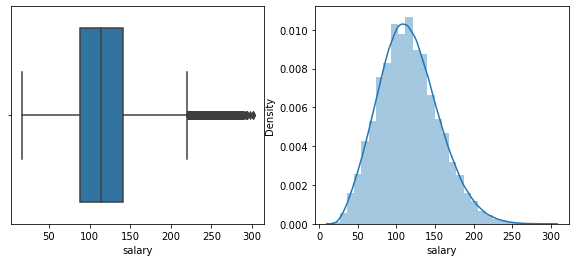

In [22]:
# show salary statistics
display(data_for_model.salary.describe())

# plot boxplot and histogram
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data_for_model.salary)
plt.subplot(1, 2, 2)
sns.distplot(data_for_model.salary, bins=30)

In [23]:
# calculate Q1, Q3 and upper bound of salary
Q1 = data_for_model.salary.quantile(0.25)
Q3 = data_for_model.salary.quantile(0.75)
upper_bound = Q3 + 1.5 * (Q3 - Q1)

# show first 10 jobs that has salary more than upper bound
display(data_for_model[data_for_model.salary.gt(upper_bound)].head(10))

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
330797,CTO,DOCTORAL,LITERATURE,FINANCE,23,15,222
274636,CEO,NONE,NONE,OIL,17,30,222
765403,CEO,DOCTORAL,ENGINEERING,WEB,17,25,235
836405,CTO,BACHELORS,MATH,OIL,21,12,231
340741,CFO,DOCTORAL,ENGINEERING,OIL,11,1,232
960536,CEO,MASTERS,CHEMISTRY,OIL,18,17,242
600785,CEO,BACHELORS,MATH,WEB,15,6,229
908756,CEO,DOCTORAL,NONE,OIL,19,27,224
826637,CEO,BACHELORS,COMPSCI,WEB,19,7,243
357671,CTO,DOCTORAL,MATH,OIL,14,7,228


#### Define function for Stat and Boxplot 

In [24]:
def show_statistics_and_boxplot(feature):
    # statistics
    display(data_for_model.groupby([feature]).salary.describe().sort_values(by='mean', ascending=False))
    
    # boxplot
    data_for_model[[feature, 'salary']].boxplot(by=feature)

##### Type of Job

,count,mean,std,min,25%,50%,75%,max
jobType,,,,,,,,
CEO,124778.0,145.311425,34.423846,55.0,120.0,142.0,167.0,298.0
CTO,125045.0,135.481067,33.090947,51.0,111.0,132.0,156.0,301.0
CFO,124369.0,135.458547,33.069203,51.0,111.0,132.0,156.0,301.0
VICE_PRESIDENT,125234.0,125.368630,31.956295,44.0,102.0,122.0,146.0,272.0
MANAGER,125120.0,115.368518,30.833865,37.0,93.0,112.0,135.0,270.0
SENIOR,125886.0,105.487775,30.069722,31.0,83.0,102.0,124.0,258.0
JUNIOR,124592.0,95.333087,29.246759,23.0,74.0,92.0,114.0,248.0
JANITOR,124971.0,70.813045,24.643021,17.0,52.0,68.0,86.0,189.0


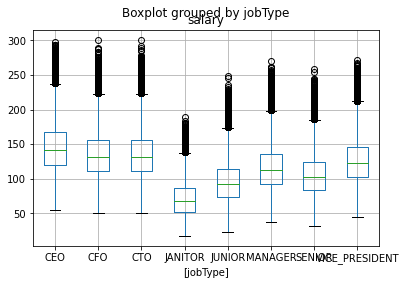

In [25]:
show_statistics_and_boxplot('jobType')

In [26]:
# jobType or the Type of Job has a strong correlation with salary

###### Type of Degree

,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
DOCTORAL,175362.0,135.490979,35.790555,45.0,109.0,132.0,158.0,301.0
MASTERS,175310.0,130.505647,35.399830,38.0,105.0,127.0,153.0,301.0
BACHELORS,175495.0,125.454663,35.042720,35.0,100.0,122.0,148.0,294.0
HIGH_SCHOOL,236975.0,101.921085,36.112684,18.0,75.0,99.0,125.0,260.0
NONE,236853.0,98.176882,34.915141,17.0,72.0,95.0,121.0,254.0


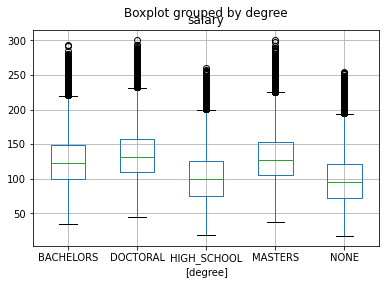

In [27]:
show_statistics_and_boxplot('degree')

In [28]:
# degree or the Type of Degree one takes has a strong correlation with salary
# Bachelor's, Master's and Doctoral degrees have much higher salary compared to those who don't have and just High School
# there are less job openings looking for/with Bachelor's, Master's and Doctoral
# there are more job openings for those without degrees and with high school attainment only

##### Type of Major

,count,mean,std,min,25%,50%,75%,max
major,,,,,,,,
ENGINEERING,58594.0,138.441342,38.178934,41.0,111.0,135.0,163.0,301.0
BUSINESS,58518.0,135.648980,37.006526,40.0,109.0,132.0,159.0,294.0
MATH,57800.0,133.322042,35.539246,39.0,107.0,130.0,156.0,280.0
COMPSCI,58382.0,132.075605,34.776640,41.0,107.0,129.0,154.0,286.0
PHYSICS,58410.0,130.372436,34.956981,38.0,105.0,127.0,153.0,293.0
CHEMISTRY,58875.0,129.072085,34.832396,40.0,104.0,126.0,151.0,282.0
BIOLOGY,58379.0,127.932664,34.820141,35.0,103.0,125.0,150.0,285.0
LITERATURE,58684.0,124.423097,33.576413,37.0,100.0,122.0,146.0,271.0
NONE,532353.0,102.583864,36.136268,17.0,76.0,100.0,126.0,270.0


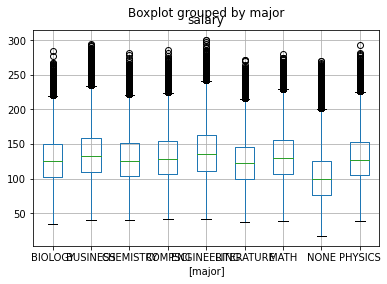

In [29]:
show_statistics_and_boxplot('major')

In [30]:
# those who majored in engineering and business have high salary offers
# those who majored in literature have low salary offers among those with degrees
# those with no degrees have the lowest salary offers

##### Type of Industry

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
OIL,142770.0,130.953863,38.528558,37.0,103.0,128.0,156.0,301.0
FINANCE,142866.0,130.747659,38.319820,36.0,103.0,128.0,156.0,294.0
WEB,143205.0,121.645362,38.165659,31.0,94.0,119.0,146.0,290.0
HEALTH,142755.0,115.735540,36.865179,28.0,89.0,114.0,140.0,275.0
AUTO,142941.0,109.435222,36.091590,25.0,84.0,108.0,133.0,264.0
SERVICE,142639.0,104.446820,35.577606,22.0,79.0,103.0,128.0,256.0
EDUCATION,142819.0,99.448386,35.110257,17.0,75.0,98.0,122.0,253.0


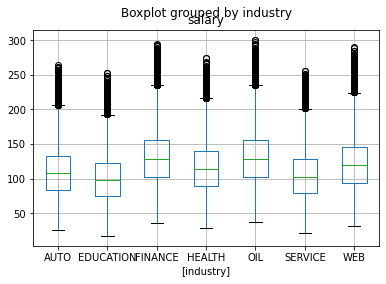

In [31]:
show_statistics_and_boxplot('industry')

In [32]:
# oil and finance industries have the highest salaries or offer the most

##### Years Experience

In [33]:
data_for_model[['yearsExperience','salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
yearsExperience,999995.0,11.992407,7.212390,0.0,6.0,12.0,18.0,24.0
salary,999995.0,116.062398,38.717163,17.0,88.0,114.0,141.0,301.0


<AxesSubplot:xlabel='yearsExperience'>

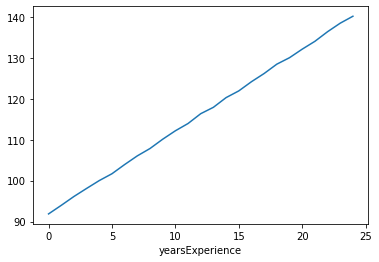

In [34]:
data_for_model.groupby(['yearsExperience']).salary.mean().plot(x='yearsExperience', y='salary')

In [35]:
# the more number of years of experience one has, the higher the salary is offered

##### Miles from metropolis

In [36]:
data_for_model[['milesFromMetropolis','salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
milesFromMetropolis,999995.0,49.529381,28.877721,0.0,25.0,50.0,75.0,99.0
salary,999995.0,116.062398,38.717163,17.0,88.0,114.0,141.0,301.0


<AxesSubplot:xlabel='milesFromMetropolis'>

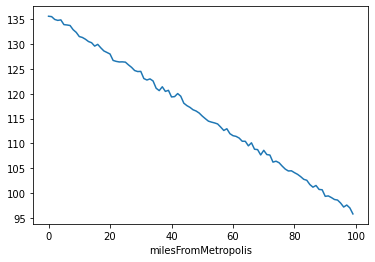

In [37]:
data_for_model.groupby(['milesFromMetropolis']).salary.mean().plot(x='milesFromMetropolis', y='salary')

In [38]:
# the closer you are to the metropolis, the higher the salary is offered

## Model

##### Split input and output variables

In [39]:
X = data_for_model.drop(["salary"], axis = 1)
y = data_for_model["salary"]

##### Split out training and test sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##### Deal with categorical variables

In [41]:
categorical_vars = ['jobType', 'degree', 'major', 'industry']

In [42]:
one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

In [43]:
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

In [44]:
encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

In [45]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)
X_train_encoded.head(5)

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)
X_test_encoded.head(5)

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Model Training

In [47]:
regressor = DecisionTreeRegressor(random_state = 42, max_depth = 4)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

## Model Assessment

In [48]:
# predict on the test set
y_pred = regressor.predict(X_test)

In [49]:
# calculate r-squared
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.463314655624843


In [50]:
# cross validation (CV)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = "r2")
cv_scores.mean()

0.4630829955994768

In [51]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.46324219259621313


## Finding the Max Depth

In [52]:
max_depth_list = list(range(1,9))
accuracy_scores = []

In [53]:
for depth in max_depth_list:
    
    regressor = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    accuracy = r2_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

In [54]:
max_accuracy = max(accuracy_scores)
max_accuracy

0.6271575321564593

In [55]:
max_accuracy_idx = accuracy_scores.index(max_accuracy)
max_accuracy_idx

7

In [56]:
optimal_depth = max_depth_list[max_accuracy_idx]
optimal_depth

8

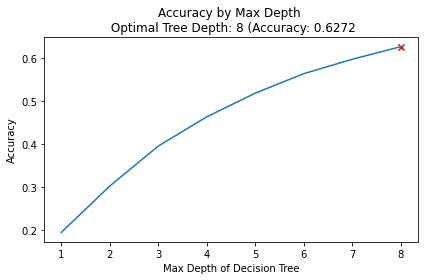

In [57]:
# plot of max depths
plt.plot(max_depth_list, accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker = "x", color = "red")
plt.title(f"Accuracy by Max Depth \n Optimal Tree Depth: {optimal_depth} (Accuracy: {round(max_accuracy, 4)}")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

## Deploy

#### Apply the model on the test data

In [58]:
to_predict = test_data
to_predict.head(2)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47


In [59]:
to_predict.drop(["jobId", "companyId"], axis=1, inplace=True)
to_predict.head(5)

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JUNIOR,NONE,NONE,AUTO,20,47
2,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [60]:
categorical_vars = ['jobType', 'degree', 'major', 'industry']

In [61]:
encoder_vars_array = one_hot_encoder.transform(to_predict[categorical_vars])

In [62]:
encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

In [63]:
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)
to_predict = pd.concat([to_predict.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)
to_predict.drop(categorical_vars, axis = 1, inplace = True)

In [64]:
salary_predictions = regressor.predict(to_predict)
salary_predictions

array([110.98001873, 113.58646876, 160.84377377, ...,  58.55395683,
       146.42921469, 106.67695841])

In [65]:
to_predict['salary'] = salary_predictions

In [66]:
to_predict.head(5)

,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,salary
0,22,73,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,110.980019
1,20,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.586469
2,17,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,160.843774
3,14,96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,97.489139
4,10,44,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,110.652342


In [67]:
to_predict.shape

(1000000, 28)

In [68]:
corr = to_predict.corr()

<AxesSubplot:>

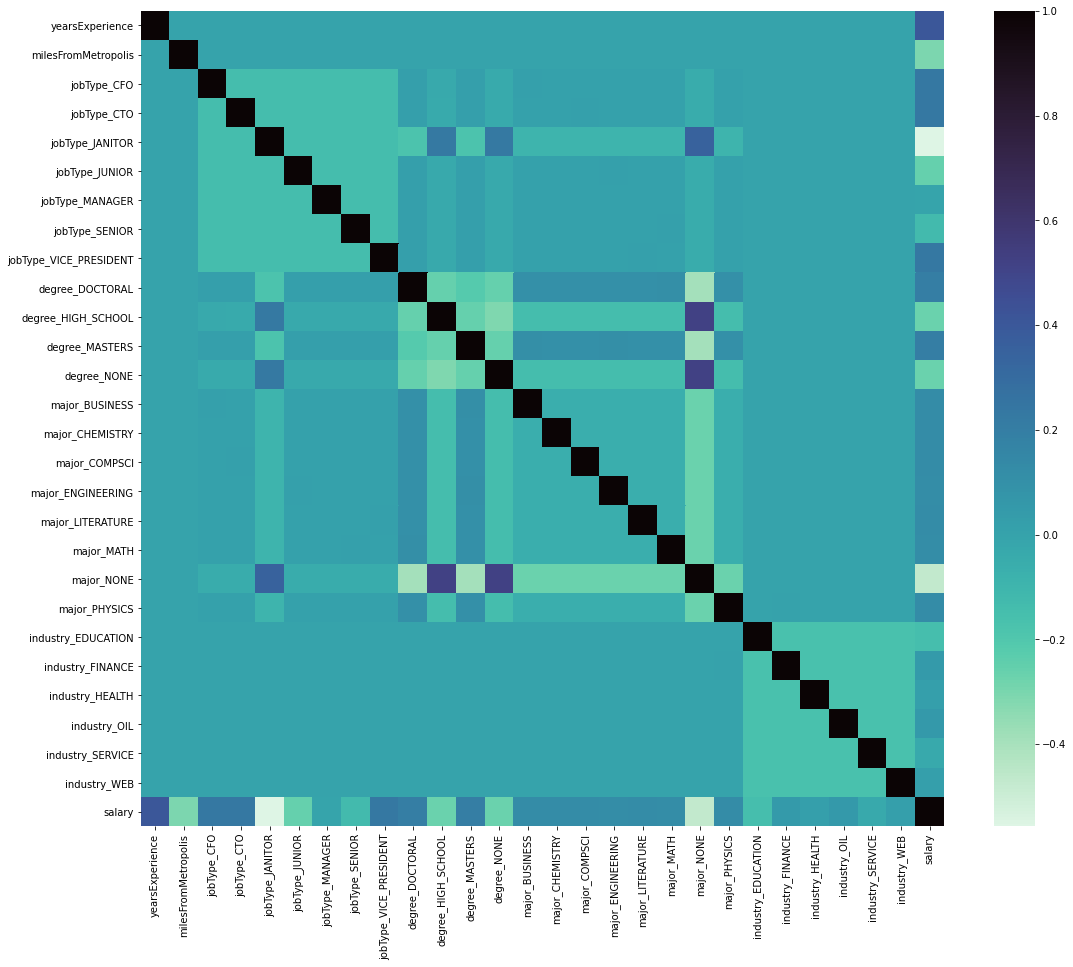

In [69]:
plt.figure(figsize = (18,15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="mako_r")